In [ ]:
COLORS = {
    'reset': '\033[0m',

    'red': '\033[31m',
    'green': '\033[32m',
    'yellow': '\033[33m',
}

def GetColor(color_name: str) -> str:
    return COLORS.get(color_name, COLORS['reset'])

def Colored(text: str, color_name: str = 'green') -> str:
    return f"{GetColor(color_name)}{text}{GetColor('reset')}"


In [99]:
import numpy as np

def TransitionMatrix(matrix: list) -> np.ndarray:
    return np.array(object=matrix)


def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return np.array([people_industry, people_academia])


def CalculatePeople(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people


def PeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeople(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeople(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")


def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return np.dot(transition_matrix, people)


def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, step: int = 1,
) -> list[tuple[int, np.ndarray]]:
    
    history = [(initial_year, people.copy())]

    start = initial_year + 1
    stop  = (initial_year + period_of_time) + 1
    step = step if step > 0 else 1

    for year in range(start, stop, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append((year, people.copy()))

    return history


def UnpackData(history: list[tuple[int, np.ndarray]]) -> tuple[list[int], list[float], list[float]]:
    X_axis = [year for year, _ in history]
    Y_axis_industry = [people[0] for _, people in history]
    Y_axis_academia = [people[1] for _, people in history]
    return X_axis, Y_axis_industry, Y_axis_academia

def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)


def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up



In [100]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

totalPeople = 100_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 100
finalYear = initialYear + periodOfTime

transitionMatrix = TransitionMatrix(matrix=T)

people = PeopleInitialState(
    total_people=totalPeople, 
    percentage_industry=percentagePeopleIndustry,
)

peopleHistory = SimulateYears(
    people=people,
    initial_year=initialYear,
    period_of_time=periodOfTime,
    transition_matrix=transitionMatrix,
)


In [101]:
X_axis, Y_axis_industry, Y_axis_academia = UnpackData(peopleHistory)
Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)

X_ticks = GetTicks(
    initial_value = initialYear, 
    final_value = initialYear + periodOfTime,
)
Y_ticks = GetTicks(
    dtype=float,
    final_value=Y_max, 
    initial_value=Y_min,
)


In [102]:
max_value = 0
max_key = None
changed_year_value = initialYear

for index, (year, industry, academia) in enumerate(zip(X_axis, Y_axis_industry, Y_axis_academia)):
    
    # Determine current maximum
    if industry > academia:
        current_max = industry
        current_key = 'industry'
    elif academia > industry:
        current_max = academia
        current_key = 'academia'
    else:
        current_max = industry  # they're equal
        current_key = 'equal'
    
    if index == 0:
        # Initialize for first iteration
        max_value = current_max
        max_key = current_key
        changed_year_value = year
        print(f"[{Colored('STARTED')}] Initial max value: {Colored(f'{max_value:.2f}', 'yellow')} in year {Colored(f'{year}', 'yellow')} ({Colored(f'{current_key}', 'yellow')})")
    
    else:
        # Check if the leader (industry vs academia) has changed
        if current_key != max_key:
            max_value = current_max
            max_key = current_key
            changed_year_value = year
            print(f"[{Colored('CHANGED')}] Max changed to: {Colored(f'{current_max:.2f}', 'yellow')} in the year {Colored(f'{year}', 'yellow')} ({Colored(f'{current_key}', 'yellow')})")
        # Update max_value if current leader has grown but leadership hasn't changed
        elif current_max > max_value:
            max_value = current_max

print(f"\nFinal maximum value: {max_value:.2f} ({max_key})")

[STARTED] Initial max value: 90000.00 in year 2025 (academia)
[CHANGED] Max changed to: 53212.39 in the year 2028 (industry)

Final maximum value: 95238.10 (industry)


In [103]:
time_for_change = abs(initialYear - changed_year_value)
print(f"Time for change: [{Colored(f'{time_for_change} years')}]")

Time for change: [3 years]


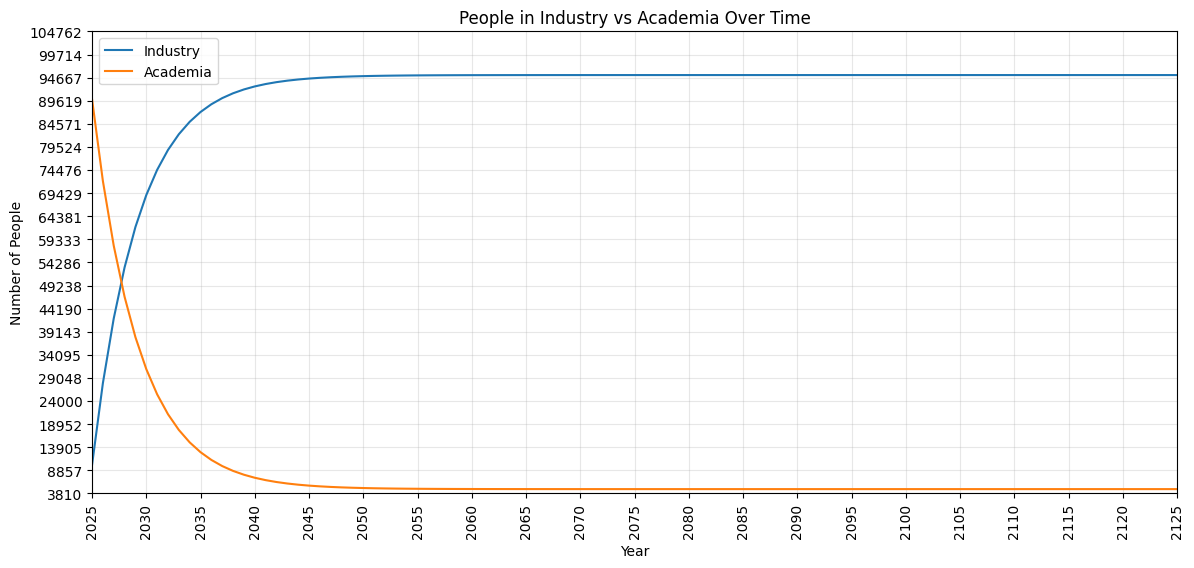

In [104]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(X_axis, Y_axis_industry, label='Industry')
plt.plot(X_axis, Y_axis_academia, label='Academia')

plt.xticks(X_ticks); plt.yticks(Y_ticks)
plt.ylim(Y_min, Y_max); plt.xlim(initialYear, finalYear)

plt.title('People in Industry vs Academia Over Time')
plt.xlabel('Year'); plt.ylabel('Number of People')
plt.xticks(rotation=90)

plt.legend(); plt.grid(alpha=0.3); plt.show()
